# Downstream Analyses of Factor Loadings

Here we use the loadings obtained with Tensor-cell2cell for each element in their respective dimensions (contexts, ligand-receptor pairs, sender cells, receiver cells). These loadings represent the importance of each element in a given factor or latent pattern. We can use this information to gain more insights about the biological processes underlying each of the communication patterns.

In [1]:
library(liana, quietly = TRUE)

library(dplyr, quietly = TRUE)

library(patchwork, quietly = TRUE)
library(ggplot2, quietly = TRUE)

library(purrr, quietly = TRUE)
library(forcats, quietly = TRUE)
library(tidyr, quietly = TRUE)
library(rstatix, quietly = TRUE)
library(ggpubr, quietly = TRUE)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘rstatix’


The following object is masked from ‘package:stats’:

    filter




## Directories

In [2]:
output_folder <- file.path('..', '..', 'data', 'tc2c-outputs')
data_path <- file.path('..', '..', 'data')

## Load Data

**Load the SingleCellExperiment object with the stored loadings obtained from the tensor factorization**

In [3]:
covid_data <- readRDS(file.path(data_path, 'covid_data_sce.rds'))

## Downstream Analyses

### Boxplots to statistically compare group of samples/contexts

The statistical test can be changed by modifying the parameters. An FDR correction is applied to the p-values. 

```statistical_test='t-test_ind'```

```pval_correction='benjamini-hochberg'```

In [4]:
sample_loadings <- liana::get_c2c_factors(covid_data,
                                          sample_col='sample_new',
                                          group_col='condition') %>%
                                          purrr::pluck("contexts") %>% 
                                          pivot_longer(-c("condition", "context"),
                                                names_to = "factor",
                                                values_to = "loadings") %>% 
                                          mutate(factor = factor(factor)) %>%
                                          mutate(factor = fct_relevel(factor, "Factor.10", after=9))

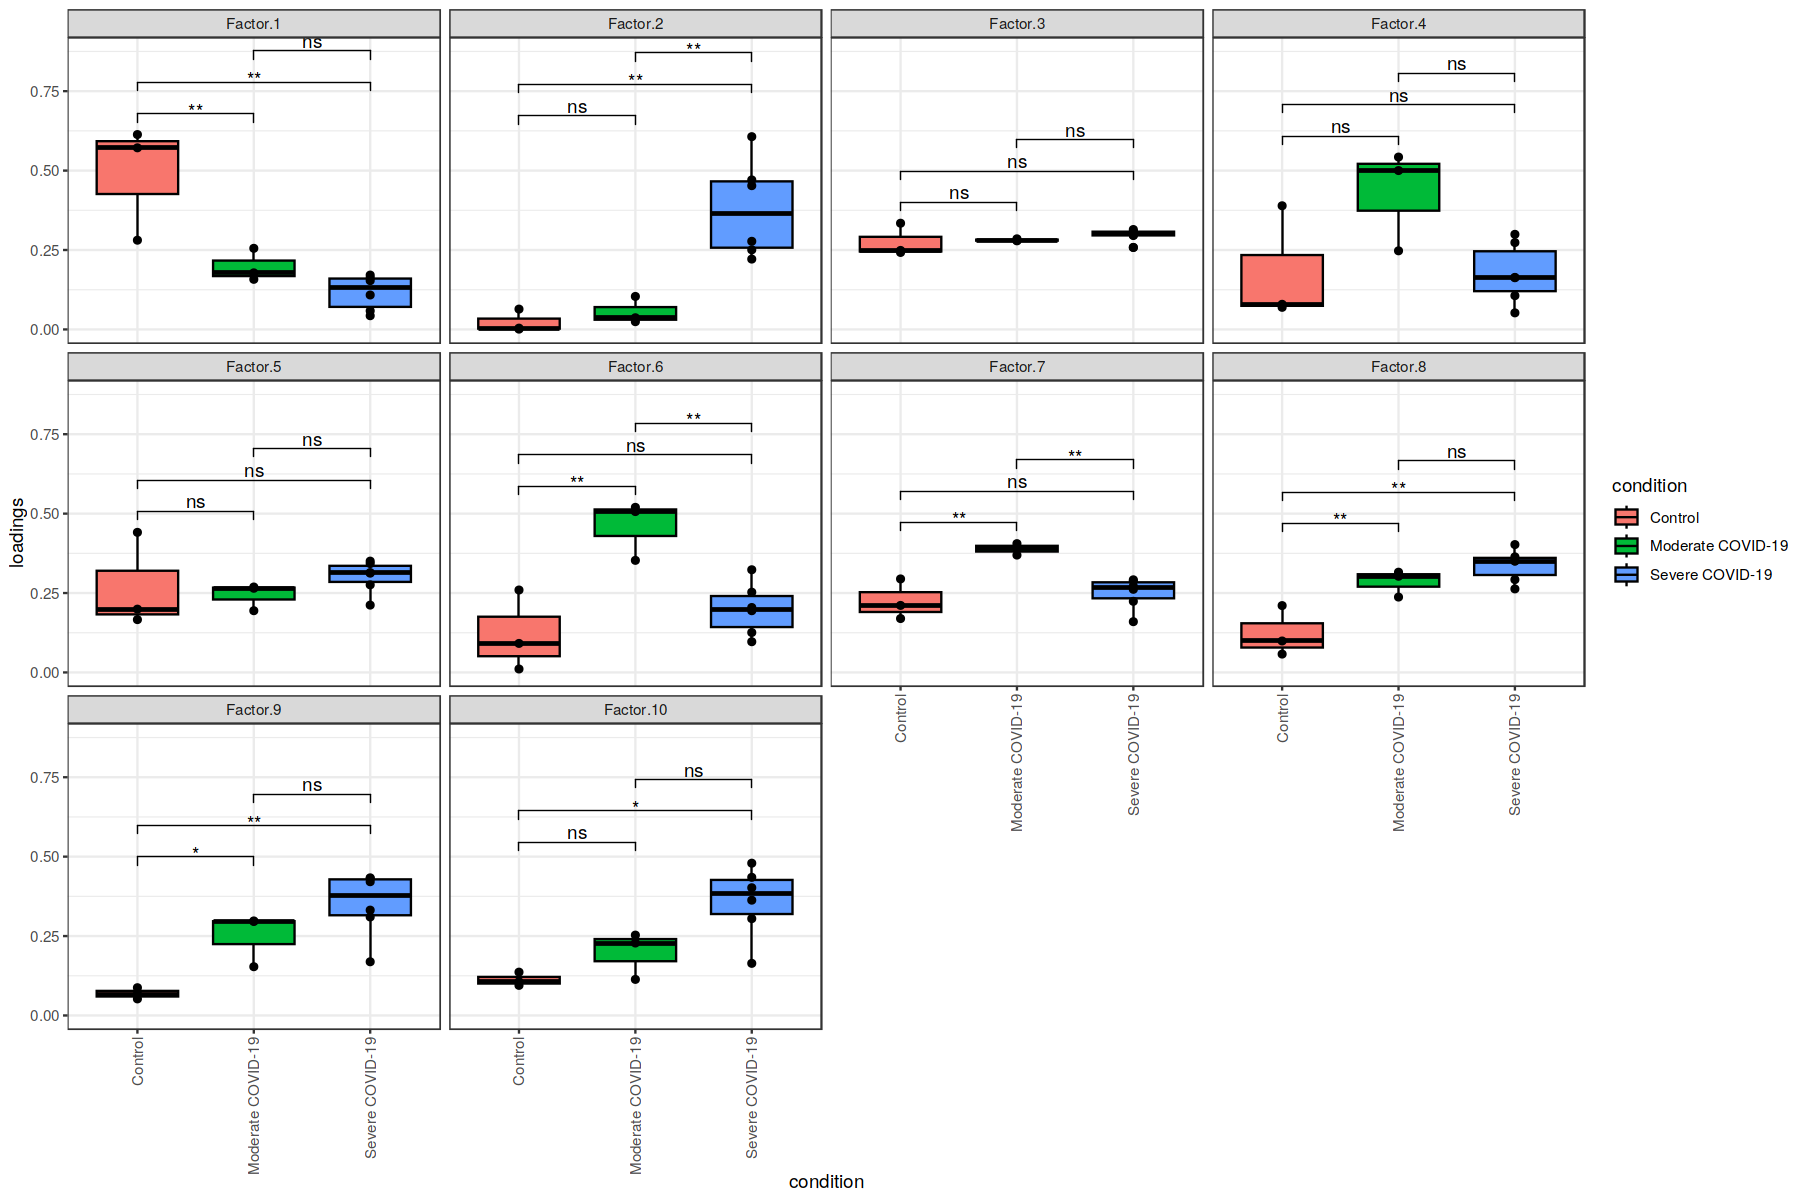

In [5]:
h_ = 10
w_ = 15
options(repr.plot.height=h_, repr.plot.width=w_)

# Do pairwise tests
pwc <- sample_loadings %>%
    group_by(factor) %>%
    rstatix::pairwise_t_test(
      loadings ~ condition, 
      p.adjust.method = "fdr"
      )

# plot
pwc <- pwc %>% add_xy_position(x = "condition")
ggboxplot(sample_loadings, x = "condition", y = "loadings", add = "point", fill="condition") +
    facet_wrap(~factor, ncol = 4) +
    stat_pvalue_manual(pwc) +
    theme_bw() + 
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))
    

Here, we see that the communication patterns (or context loadings) identified statistically significant patterns when comparing each pair of COVID-19 severities.

These factors thus represent differences in the ligand-receptor interactions as well as cell types participating in cell-cell communication among the different COVID-19 severities.

### Correlation between Context Loadings & COVID-19 Severity

We first define the ranking of the severity, where higher values represent the worst severity.

In [6]:
severity_rank<-function(x){
    if (x == 'Control'){
        ranking = 1
    }else if (x == 'Moderate COVID-19'){
        ranking = 2
    }else if (x == 'Severe COVID-19'){
        ranking = 3
    }
}

In [7]:
factors <- liana::get_c2c_factors(sce = covid_data,
                            sample_col = "sample_new",
                            group_col = "condition")
sev_rank <- data.frame(condition = factors$contexts$condition, 
                        severity.ranking = sapply(factors$contexts$condition, function(x) severity_rank(x)))
head(sev_rank)

,condition,severity.ranking
,<fct>,<dbl>
1,Control,1
2,Control,1
3,Control,1
4,Moderate COVID-19,2
5,Moderate COVID-19,2
6,Moderate COVID-19,2


Number of factors from the tensor decomposition

In [8]:
nfactors <- dim(factors$contexts %>% dplyr::select(starts_with("Factor")))[[2]]

**Spearman correlation**

In [9]:
for (i in 1:nfactors){
    factor <- paste0('Factor.', i)
    suppressWarnings({
        s.cor<-cor.test(factors$contexts[[factor]], sev_rank$severity.ranking, 
            method = 'spearman')        
    })

    s.r<-format(round(s.cor$estimate[['rho']], 2), nsmall = 2)
    s.p<-format(round(s.cor$p.value, 3), nsmall = 3)
    print(paste0(factor, ' has a Spearman correlation of ', s.r, 
                 ' with an associated p-value of ', s.p))
    
}

[1] "Factor.1 has a Spearman correlation of -0.85 with an associated p-value of 0.000"
[1] "Factor.2 has a Spearman correlation of 0.88 with an associated p-value of 0.000"
[1] "Factor.3 has a Spearman correlation of 0.41 with an associated p-value of 0.186"
[1] "Factor.4 has a Spearman correlation of -0.10 with an associated p-value of 0.751"
[1] "Factor.5 has a Spearman correlation of 0.42 with an associated p-value of 0.173"
[1] "Factor.6 has a Spearman correlation of 0.02 with an associated p-value of 0.944"
[1] "Factor.7 has a Spearman correlation of -0.15 with an associated p-value of 0.646"
[1] "Factor.8 has a Spearman correlation of 0.79 with an associated p-value of 0.002"
[1] "Factor.9 has a Spearman correlation of 0.85 with an associated p-value of 0.000"
[1] "Factor.10 has a Spearman correlation of 0.83 with an associated p-value of 0.001"


### Heatmaps

**Cluster samples/contexts by their importance across factors**

Here we provide a example on clustering samples given their respective loadings, colored by category of COVID-19 condition:

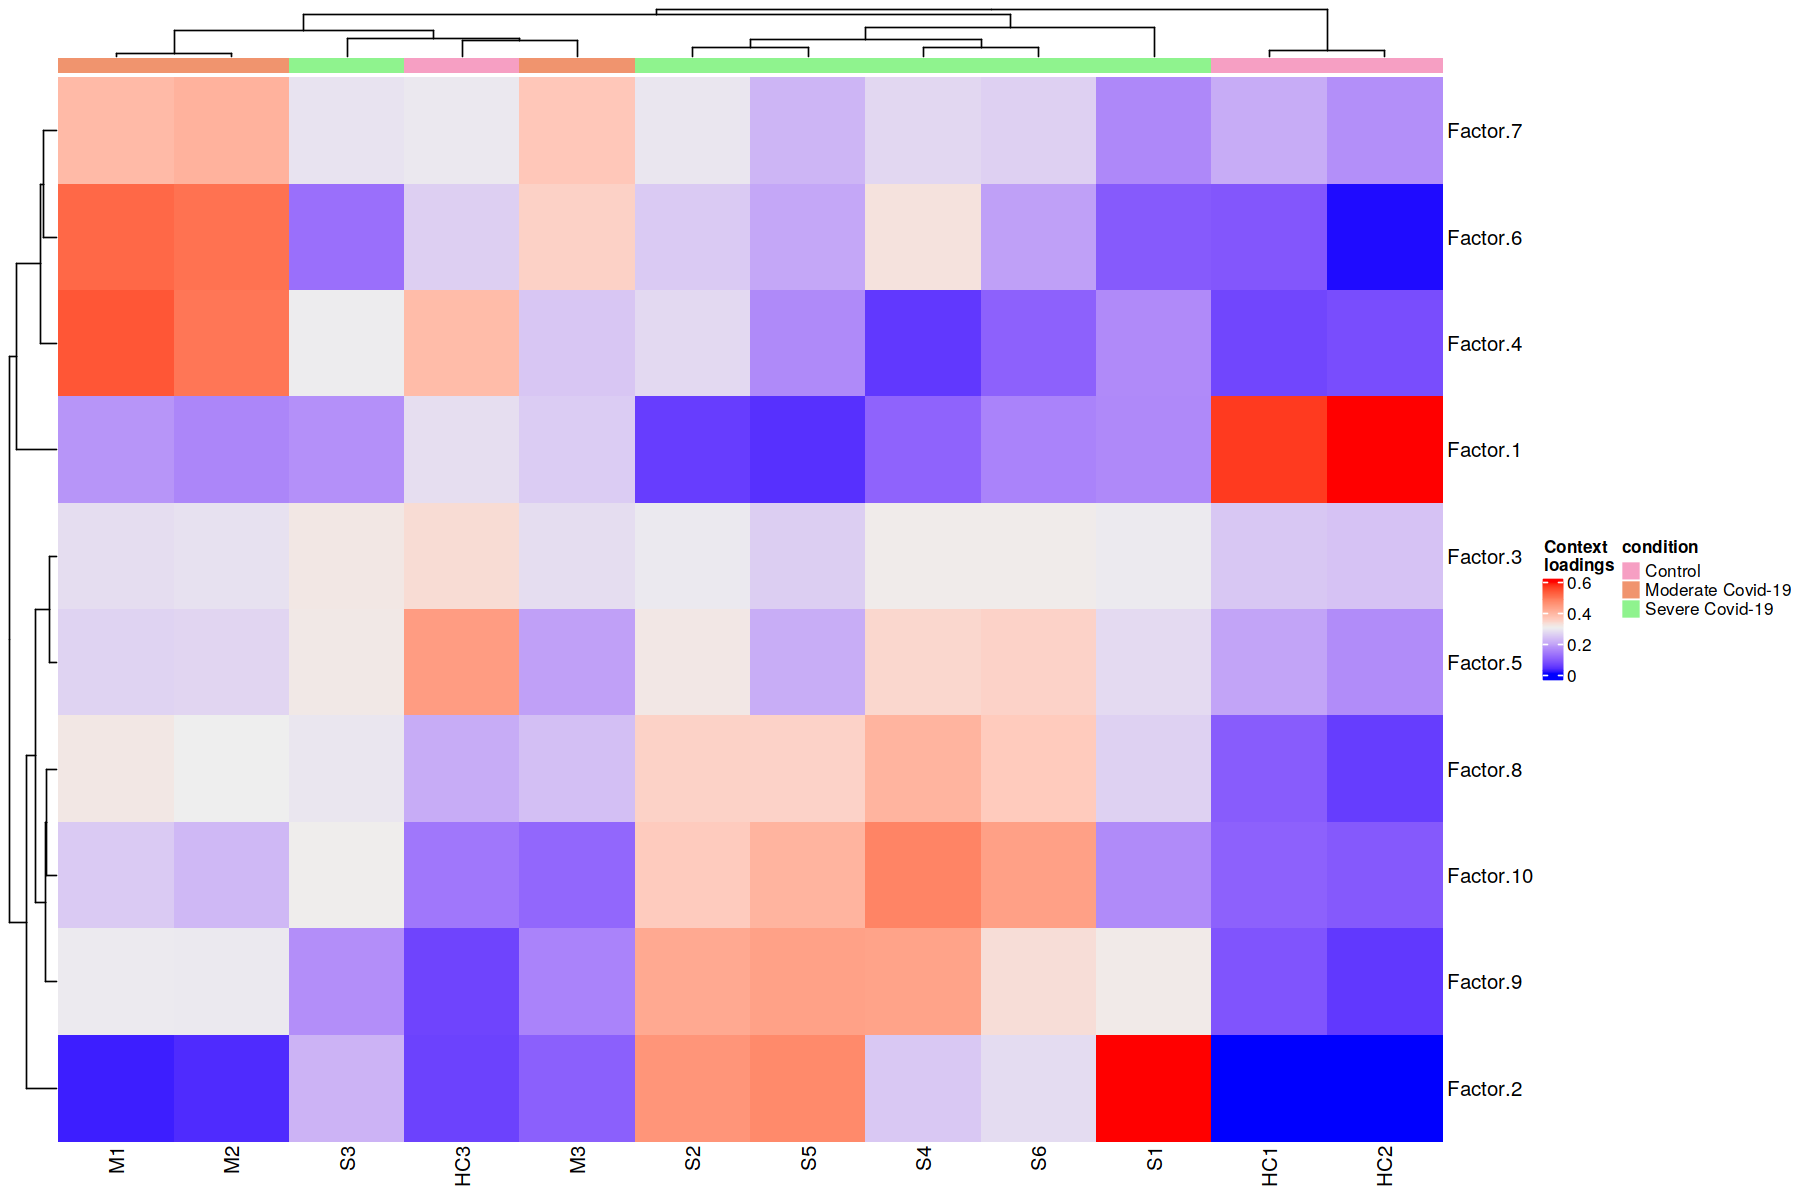

In [10]:
liana::plot_context_heat(sce = covid_data,
                sample_col = "sample_new",
                group_col = "condition")

Here patients are grouped by the importance that each communication pattern (factor) has in relation to the other patients. This captures combinations of related communication patterns that explain similarities and differences at a sample-specific resolution. In this case the differences are reflected with an almost perfect clustering by COVID-19 severity, where moderate cases are more similar to control cases.

**Cluster LR pairs by their importance across factors**

To consider important LR pairs in at least one factor, we can set a threshold to filter for the top n (fraction or number) of LR pairs. This value can be obtained in the way that user thinks is pertinent. Here we use ```n=05``` to filter for the top 5 LR pairs <span style='color:red'> per factor

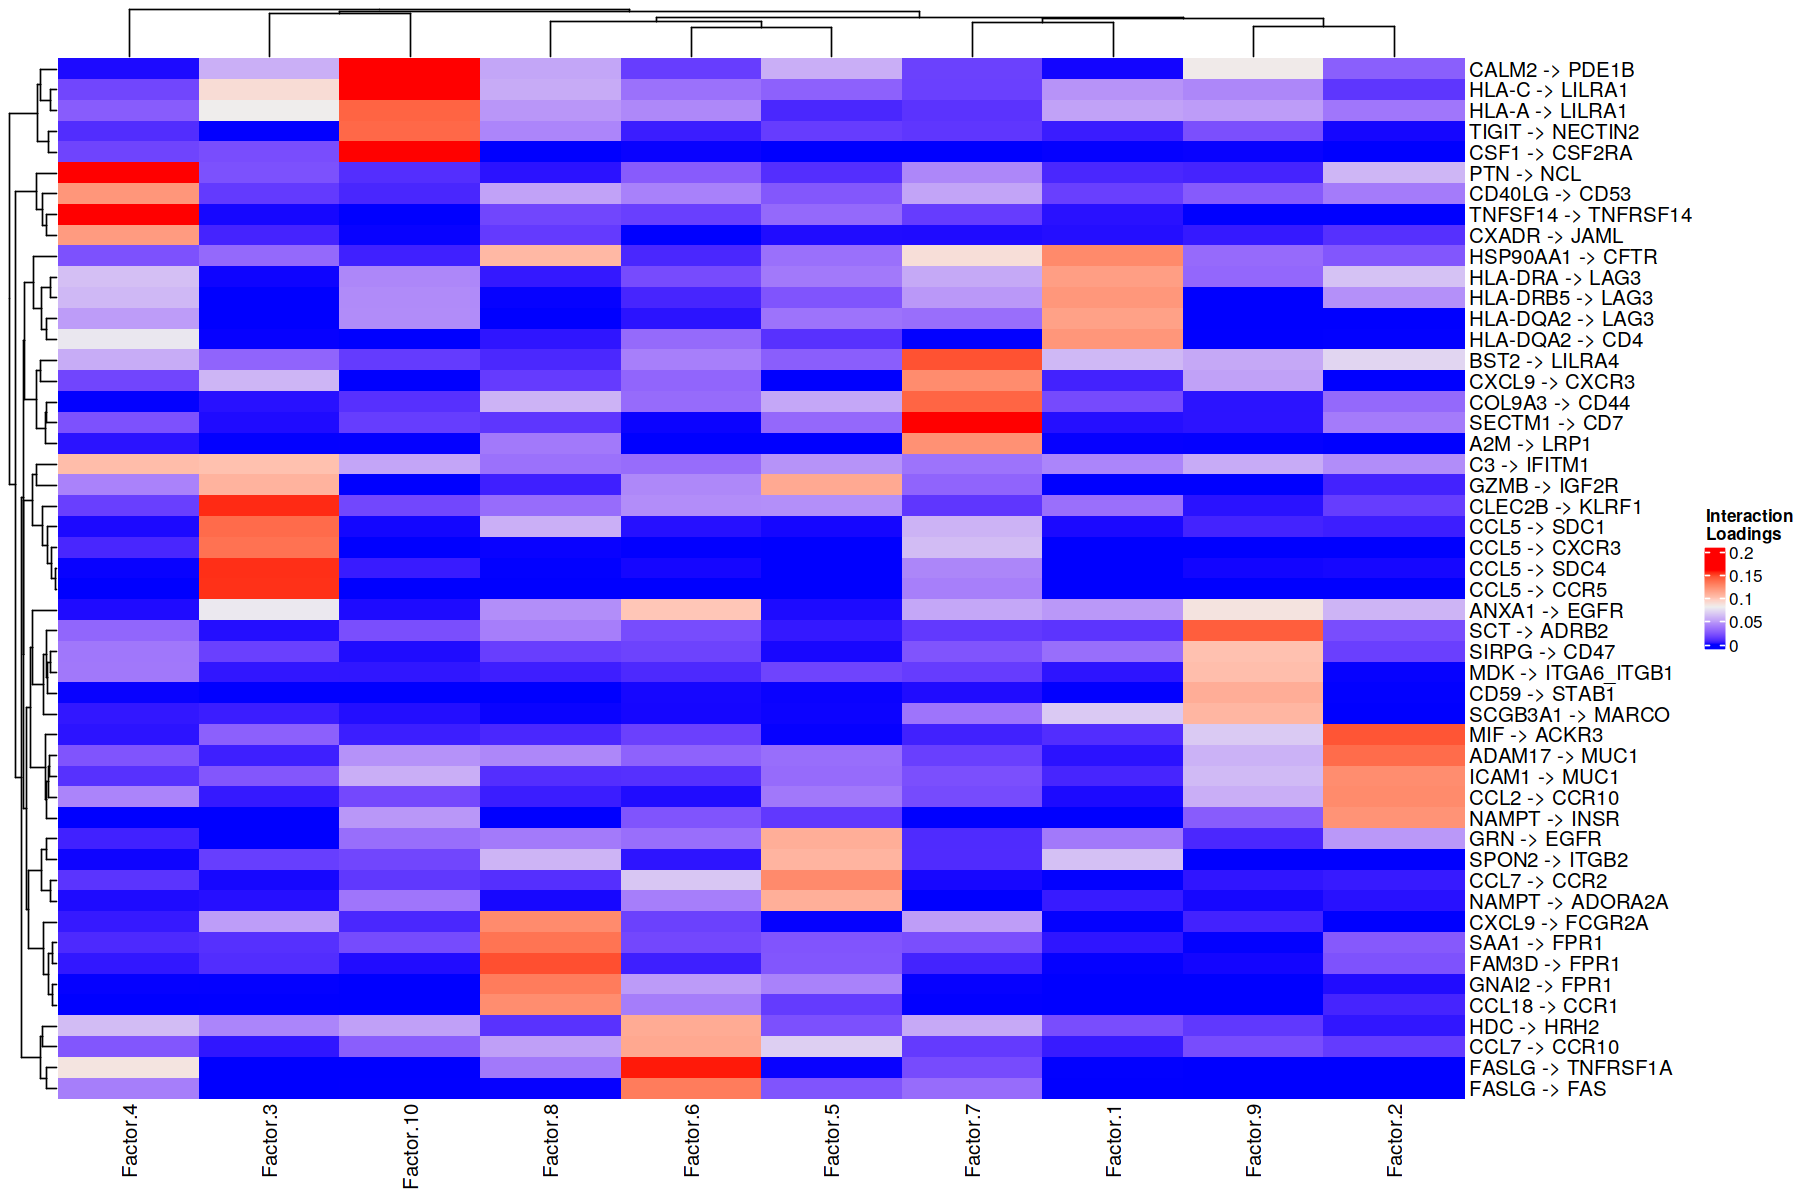

In [11]:
liana::plot_lr_heatmap(sce = covid_data,  n = 5)

In this case, LR pairs are grouped according to how important they for one factor versus the others. This can give an idea of the molecular mechanisms that are crucial in each communication pattern.

**Cluster sender-receiver pairs for an specific factor**

Factor 8 is associated with COVID-19 cases (see boxplots). Thus, it would be interesting to determine the cellular interactions underlying this communicatino pattern. To do so, we define its Loading Product between senders and receiver cells (outer product of loadings for that factor), which represents the joint importance of the cell-cell pair:

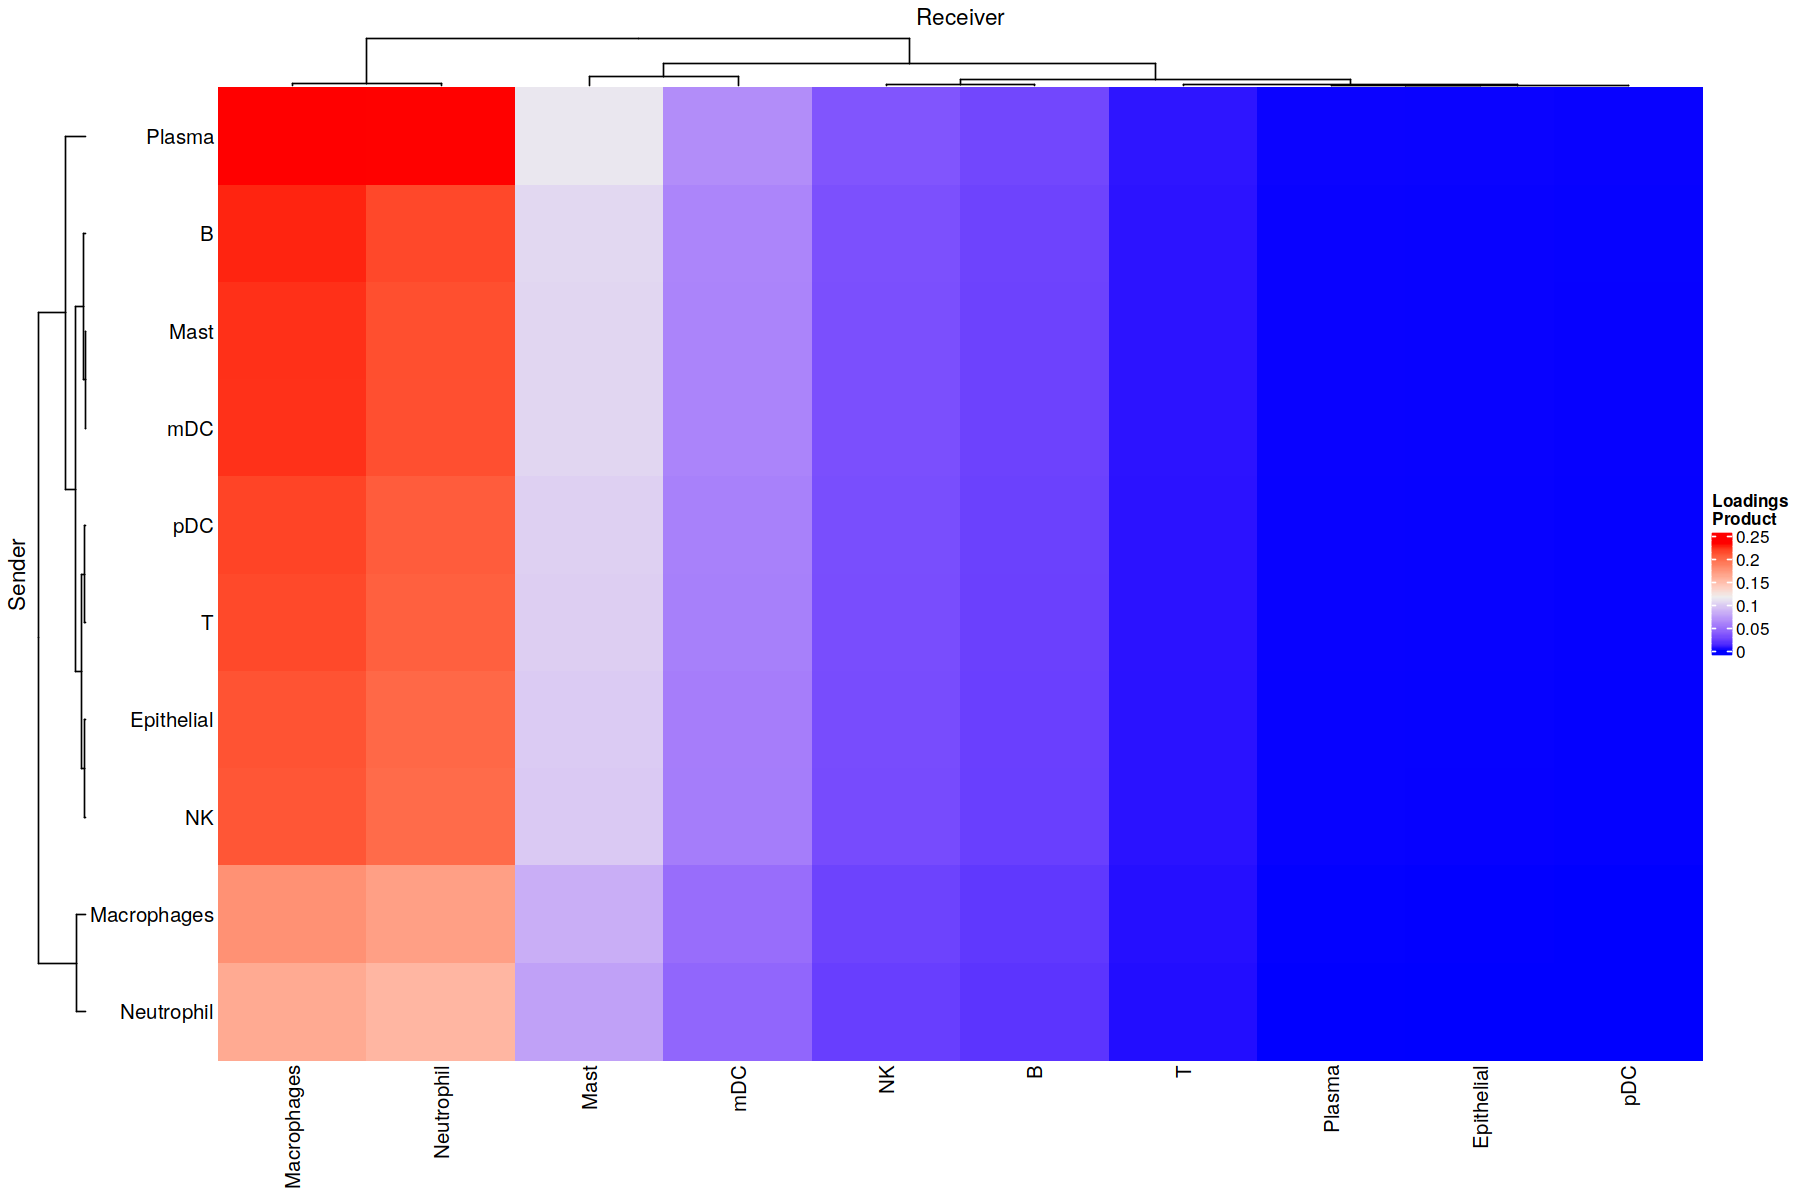

In [12]:
selected_factor <- 'Factor.8'
liana::plot_c2c_cells(sce = covid_data,
                   factor_of_int = selected_factor,
                   name = "Loadings \nProduct")

### Gini coefficients of the factor-specific cell-cell communication

The Gini coefficient quantifies the extent to which sender-receiver cell pairs differ within a factor according to their importance as measured by their loadings. Here it is use to measure the imbalance of communication for a given factor. In other words, it identifies whether a few cells are key for an identified pattern (low Gini coefficient) or whether the pattern corresponds to a general process that involves most of the cell types (high Gini coefficient). Gini coefficients range between [0, 1].

**Note that here we show ginis seperately for sender and receiver cell types per factor, while in Python we show the combined gini for sender and receiver cell types**

In [13]:
# Get loadings for source/sender Cell types
calculate_gini(factors$senders)

factor,gini
<chr>,<dbl>
Factor.1,0.26620332
Factor.10,0.18291371
Factor.2,0.19139442
Factor.3,0.44600727
Factor.4,0.45065451
Factor.5,0.69849533
Factor.6,0.61614648
Factor.7,0.26313404
Factor.8,0.06311132


In [14]:
# Get loadings for source/sender Cell types
calculate_gini(factors$receiver)

factor,gini
<chr>,<dbl>
Factor.1,0.08450890
Factor.10,0.47924666
Factor.2,0.10965235
Factor.3,0.13653466
Factor.4,0.09516758
Factor.5,0.14736890
Factor.6,0.10340490
Factor.7,0.50656589
Factor.8,0.69806038


For senders, we observe that the lowest Gini coefficient was obtained by Factor 2, which seems to have more balanced cell loadings. Similarly, for receivers, the lowest Gini coefficient is in Factor 10. For each of these factors respectively, senders and receivers are more similar or homogeneous.